In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
from utils import data

In [3]:
from cohorts.functions import *

In [4]:
from cohorts.variant_filters import *

In [5]:
from utils.data import rizvi_filter

In [6]:
from cohorts.varcode_utils import FilterableVariant

In [7]:
def filter_30(filterable_variant):
    somatic_stats = variant_stats_from_variant(filterable_variant.variant,
                                               filterable_variant.variant_metadata)
    return (
        somatic_stats.tumor_stats.depth >= 30 and
        somatic_stats.normal_stats.depth >= 30 and
        somatic_stats.tumor_stats.alt_depth >= 5 and
        (1 - somatic_stats.normal_stats.variant_allele_frequency) > 0.97
    )

In [8]:
depth_to_filter_fn = {7: rizvi_filter, 0: no_filter, 30: filter_30}
cohorts_with_bqsr = {}
cohorts_without_bqsr = {}

In [9]:
for depth, filter_fn in depth_to_filter_fn.items():
    cohorts_with_bqsr[filter_fn] = data.init_cohort(min_coverage_normal_depth=depth,
                                                    min_coverage_tumor_depth=depth,
                                                    print_provenance=False)
    cohorts_without_bqsr[filter_fn] = data.init_cohort(
        min_coverage_normal_depth=depth,
        min_coverage_tumor_depth=depth,
        without_bqsr=True, 
        cache_data_dir="/home/tavi/bladder-analyses/data/cache-without-bqsr",
        print_provenance=False)

Overriding VCF dir (/home/tavi/ct/bladder/vcfs-indelrealigned-bqsr) to use without-BQSR VCFs: /home/tavi/ct/bladder/vcfs


Overriding VCF dir (/home/tavi/ct/bladder/vcfs-indelrealigned-bqsr) to use without-BQSR VCFs: /home/tavi/ct/bladder/vcfs


Overriding VCF dir (/home/tavi/ct/bladder/vcfs-indelrealigned-bqsr) to use without-BQSR VCFs: /home/tavi/ct/bladder/vcfs


In [10]:
from cohorts.model import *

In [11]:
from utils.paper import *

In [12]:
from numpy.random import seed

In [13]:
seed(1234)

In [14]:
function_descriptions = {}
function_descriptions[rizvi_filter] = "Tumor/Normal Depth ≥ 7, Tumor VAF > 0.1, Normal VAF < 0.03"
function_descriptions[filter_30] = "Tumor/Normal Depth ≥ 30, Tumor Alt Depth ≥ 5"
function_descriptions[no_filter] = "No Depth/VAF Filters"

In [15]:
def description_formatter(func):
    return function_descriptions[func]

In [16]:
def get_impact_mutations(cohort):
    hugo_translation = pd.read_csv(path.join(data.REPO_DATA_DIR, 'hugo-ensembl-map.txt'), sep='\t')[[
            'Approved Symbol', 'Previous Symbols']].dropna()
    hugo_translation_map = {}
    for previous_symbols, symbol in zip(hugo_translation['Previous Symbols'], hugo_translation['Approved Symbol']):
        previous_symbols = previous_symbols.split(',')
        for old_symbol in previous_symbols:
            hugo_translation_map[old_symbol] = symbol

    impact_mutations = pd.read_csv(path.join(data.REPO_DATA_DIR, 'bladder-impact.txt'), sep='\s+')
    impact_mutations = impact_mutations[impact_mutations['Prot'].notnull()]
    impact_mutations['effect_description'] = 'p.' + impact_mutations.Prot.str.upper()
    impact_mutations.rename(columns={'Gene': 'gene_name', 'StudyID': 'patient_id'}, inplace=True)
    impact_mutations['patient_id'] = impact_mutations['patient_id'].astype(str)
    impact_mutations = impact_mutations[~impact_mutations['effect_description'].str.contains('FS')]
    impact_mutations = impact_mutations[~impact_mutations['effect_description'].str.contains('DEL')]
    impact_mutations = impact_mutations[~impact_mutations['effect_description'].str.contains('INS')]


    gene_conversions = {
        'MLL' : 'KMT2A',
        'MLL2' : 'KMT2D',
        'MLL3' : 'KMT2C',
        'CDKN2Ap16INK4A' : 'CDKN2A',
        'CDKN2Ap14ARF' : 'CDKN2A'
    }

    impact_mutations.gene_name = impact_mutations.gene_name.map(lambda g: gene_conversions.get(g, g))

    impact_mutations.gene_name = impact_mutations.gene_name.map(lambda g: hugo_translation_map.get(g, g))

    impact_mutations = impact_mutations[~impact_mutations.patient_id.isin(set(['4072', '7592']))]

    PATIENTS_WITH_IMPACT = set(impact_mutations.patient_id).intersection(set(cohort.as_dataframe().patient_id))
    return impact_mutations, PATIENTS_WITH_IMPACT

In [17]:
def calculate_precision(cohort, filter_fn=None):
    impact_mutations, PATIENTS_WITH_IMPACT = get_impact_mutations(cohort)
    variants = cohort.load_variants(filter_fn=filter_fn)
    
    from pyensembl import ensembl75
    from varcode.effects import Substitution

    def parse_impact_genes():
        impact_df = pd.read_csv(path.join(data.REPO_DATA_DIR, 'impact_gene_list.csv'))
        impact_ensembl_ids = {}

        for gene_symbol in impact_df['Hugo_symbol']:
            try:
                gene_ids = ensembl75.gene_ids_of_gene_name(gene_symbol)
                for id in gene_ids:
                    impact_ensembl_ids[id] = gene_symbol
            except:
                continue
        return impact_ensembl_ids

    impact_ensembl_ids = parse_impact_genes()
    def effect_impact_filter(filterable_effect):
        if filter_fn is None:
            return filterable_effect.effect.gene_id in impact_ensembl_ids
        else:
            return filter_fn(filterable_effect) and filterable_effect.effect.gene_id in impact_ensembl_ids
    
    effects = cohort.load_effects(only_nonsynonymous=True, filter_fn=effect_impact_filter)
    from cohorts.variant_stats import variant_stats_from_variant
    
    def row_from_effect(effect):
        row = {}
        row['contig'] = effect.variant.contig
        row['start'] = effect.variant.start
        row['ref'] = effect.variant.ref
        row['alt'] = effect.variant.alt
        row['gene_id'] = effect.gene_id
        row['gene_name'] = effect.gene_name
        row['transcript_id'] = effect.transcript_id
        row['transcript_name'] = effect.transcript_name
        row['variant'] = str(effect.variant)
        row['is_snv'] = effect.variant.is_snv
        row['is_indel'] = effect.variant.is_indel
        row['is_transversion'] = effect.variant.is_transversion
        row['is_transition'] = effect.variant.is_transition
        row['effect'] = str(effect)
        row['effect_type'] = effect.__class__.__name__
        row['effect_description'] = effect.short_description
        row['nucleotide_change'] = effect.variant.ref + '>' + effect.variant.alt
        return row

    effects_sets = []
    rows = []
    for (sample, effect_collection) in effects.items():
        sample_effects = effect_collection
        for effect in sample_effects:
            fv = FilterableVariant(effect.variant, variants[sample], cohort.patient_from_id(sample))
            stats = variant_stats_from_variant(effect.variant, fv.variant_metadata)
            row = row_from_effect(effect)
            row['patient_id'] = sample
            row['TumorVAF'] = stats.tumor_stats.variant_allele_frequency
            row['TumorAltReads'] = stats.tumor_stats.alt_depth
            row['TumorDepth'] = stats.tumor_stats.depth
            row['NormalAltReads'] = stats.normal_stats.alt_depth
            row['NormalDepth'] = stats.normal_stats.depth
            rows.append(row)
    effects_df = pd.DataFrame.from_records(rows)
    effects_df = effects_df[effects_df.patient_id.isin(PATIENTS_WITH_IMPACT)]
    
    impact_mutations_all = impact_mutations.merge(
                            effects_df, 
                            how='outer', 
                            on=['patient_id', 'gene_name', 'effect_description'])
    # Prot = in IMPACT
    validated_filter = (impact_mutations_all['Prot'].notnull())
    # gene_id = in our filtered variants
    found_filter = (impact_mutations_all['gene_id'].notnull())

    impact_validated = impact_mutations_all[validated_filter]
    impact_found = impact_mutations_all[found_filter]
    impact_validated_found = impact_mutations_all[validated_filter & found_filter]
    impact_validated_missed = impact_mutations_all[validated_filter & ~found_filter]
    impact_wrong = impact_mutations_all[~validated_filter & found_filter]

    validated_missense = len(impact_validated)
    found_validated_missense = len(impact_validated_found)

    recall = float(found_validated_missense)/validated_missense 
    precision = float(found_validated_missense)/len(impact_found) 
    
    tp = len(impact_mutations_all[validated_filter & found_filter])
    tn = len(impact_mutations_all[~validated_filter & ~found_filter])
    # not in our set, but it is IMPACT
    fn = len(impact_mutations_all[validated_filter & ~found_filter])
    # in our set, but it is not IMPACT
    fp = len(impact_mutations_all[~validated_filter & found_filter])
    
    assert precision == tp / float(tp + fp)
    assert recall == tp / float(tp + fn)
    
    acc = (tp + tn) / float((fp + tp) + (fn + tn))

    f1_score  = 2* (precision * recall )/ (precision + recall)

    return (recall, precision)

inner join with ensembl_coverage: 25 to 25 rows


Mann-Whitney test: U=87.0, p-value=0.411702747006 (two-sided)


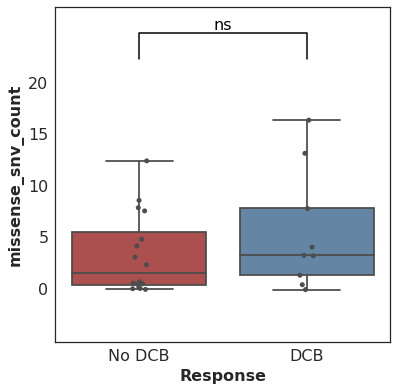

{{{with_bqsr_filter_30_auc:0.61, 95% CI (0.35, 0.85)}}}
{{{with_bqsr_filter_30_mw:n=25, Mann-Whitney p=0.41}}}
{{{with_bqsr_filter_30_recall:0.52}}}
{{{with_bqsr_filter_30_precision:0.68}}}
{{{with_bqsr_filter_30_auc_description:Tumor/Normal Depth ≥ 30, Tumor Alt Depth ≥ 5}}}


inner join with ensembl_coverage: 25 to 25 rows


Mann-Whitney test: U=94.0, p-value=0.223528962588 (two-sided)


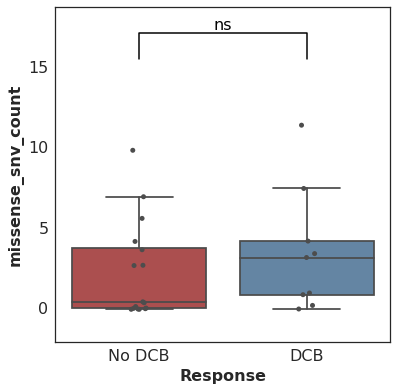

{{{with_bqsr_rizvi_filter_auc:0.65, 95% CI (0.43, 0.85)}}}
{{{with_bqsr_rizvi_filter_mw:n=25, Mann-Whitney p=0.22}}}
{{{with_bqsr_rizvi_filter_recall:0.49}}}
{{{with_bqsr_rizvi_filter_precision:0.72}}}
{{{with_bqsr_rizvi_filter_auc_description:Tumor/Normal Depth ≥ 7, Tumor VAF > 0.1, Normal VAF < 0.03}}}


inner join with ensembl_coverage: 25 to 25 rows


Mann-Whitney test: U=91.0, p-value=0.294842421401 (two-sided)


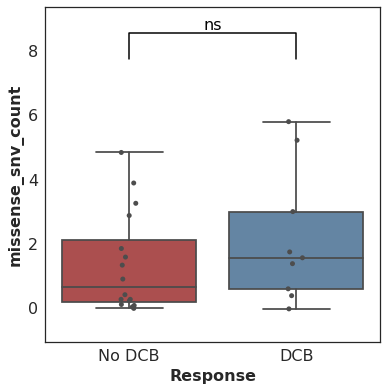

{{{with_bqsr_no_filter_auc:0.63, 95% CI (0.36, 0.86)}}}
{{{with_bqsr_no_filter_mw:n=25, Mann-Whitney p=0.29}}}
{{{with_bqsr_no_filter_recall:0.63}}}
{{{with_bqsr_no_filter_precision:0.68}}}
{{{with_bqsr_no_filter_auc_description:No Depth/VAF Filters}}}


inner join with ensembl_coverage: 25 to 25 rows


Mann-Whitney test: U=91.0, p-value=0.294935298757 (two-sided)


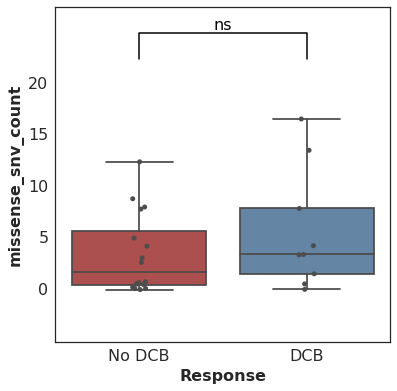

{{{without_bqsr_filter_30_auc:0.63, 95% CI (0.38, 0.86)}}}
{{{without_bqsr_filter_30_mw:n=25, Mann-Whitney p=0.29}}}
{{{without_bqsr_filter_30_recall:0.52}}}
{{{without_bqsr_filter_30_precision:0.68}}}
{{{without_bqsr_filter_30_auc_description:Tumor/Normal Depth ≥ 30, Tumor Alt Depth ≥ 5}}}


inner join with ensembl_coverage: 25 to 25 rows


Mann-Whitney test: U=104.0, p-value=0.0745315710546 (two-sided)


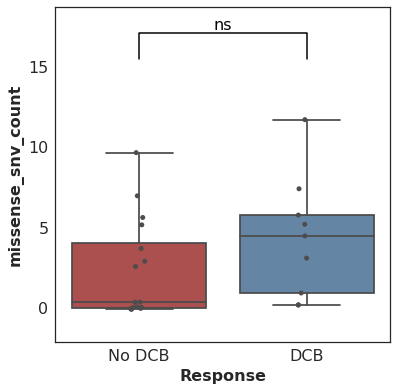

{{{without_bqsr_rizvi_filter_auc:0.72, 95% CI (0.51, 0.90)}}}
{{{without_bqsr_rizvi_filter_mw:n=25, Mann-Whitney p=0.075}}}
{{{without_bqsr_rizvi_filter_recall:0.5}}}
{{{without_bqsr_rizvi_filter_precision:0.63}}}
{{{without_bqsr_rizvi_filter_auc_description:Tumor/Normal Depth ≥ 7, Tumor VAF > 0.1, Normal VAF < 0.03}}}


inner join with ensembl_coverage: 25 to 25 rows


Mann-Whitney test: U=103.0, p-value=0.0842175169115 (two-sided)


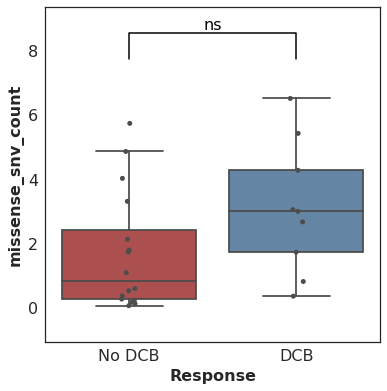

{{{without_bqsr_no_filter_auc:0.72, 95% CI (0.48, 0.90)}}}
{{{without_bqsr_no_filter_mw:n=25, Mann-Whitney p=0.084}}}
{{{without_bqsr_no_filter_recall:0.65}}}
{{{without_bqsr_no_filter_precision:0.53}}}
{{{without_bqsr_no_filter_auc_description:No Depth/VAF Filters}}}


In [18]:
for cohorts in [cohorts_with_bqsr, cohorts_without_bqsr]:
    cohort_name = "with_bqsr" if cohorts == cohorts_with_bqsr else "without_bqsr"
    for filter_fn, cohort in cohorts.items():
        series = cohort_bootstrap_auc(cohort, on=missense_snv_count, filter_fn=filter_fn)
        benefit_results = cohort.plot_benefit(on=missense_snv_count, filter_fn=filter_fn)
        plt.show()
        recall, precision = calculate_precision(cohort, filter_fn=filter_fn)
        hyper_label_printer(bootstrap_mean_formatter, label=("%s_%s_auc" % (cohort_name, filter_fn.__name__)),
            series=series)
        hyper_label_printer(mann_whitney_formatter, label=("%s_%s_mw" % (cohort_name, filter_fn.__name__)),
            results=benefit_results)
        hyper_label_printer(float_str, label=("%s_%s_recall" % (cohort_name, filter_fn.__name__)),
            f=recall)
        hyper_label_printer(float_str, label=("%s_%s_precision" % (cohort_name, filter_fn.__name__)),
            f=precision)
        hyper_label_printer(description_formatter, label=("%s_%s_auc_description" % (cohort_name, filter_fn.__name__)),
            func=filter_fn)